In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Data_for_bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns

In [3]:
tick_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']

## grid based search

In [4]:
ladder_sizing_grid = np.array([0.001,0.003,0.005,0.007,0.009])
print(ladder_sizing_grid)
position_sizing_grid = np.arange(100000,1000000,200000)
print(position_sizing_grid)

[0.001 0.003 0.005 0.007 0.009]
[100000 300000 500000 700000 900000]


In [5]:
# heat map of profits for different ladder sizing and position sizing
def profit_map(tick_data,ladder_sizing,position_sizing):
    profits = np.zeros((len(ladder_sizing),len(position_sizing)))
    U_PNLs = np.zeros((len(ladder_sizing),len(position_sizing)))
    max_positions = np.zeros((len(ladder_sizing),len(position_sizing))) 
    R_PNLs = np.zeros((len(ladder_sizing),len(position_sizing)))
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,ladder_sizing[i],position_sizing[j])
            profits[i,j]=profit
            U_PNLs[i,j]=U_PNL
            max_positions[i,j]=max_position
            R_PNLs[i,j]=R_PNL
    return profits,U_PNLs,max_positions,R_PNLs

def profit_heat_map(profits, ladder_sizing, position_sizing,title):
    plt.figure(figsize=(10,10))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True,alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, ladder_sizing)
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title(title+' Heat Map')
    plt.show()


In [78]:
profits,U_PNLs,max_positions,R_PNLs = profit_map(tick_data,ladder_sizing_grid,position_sizing_grid)

KeyboardInterrupt: 

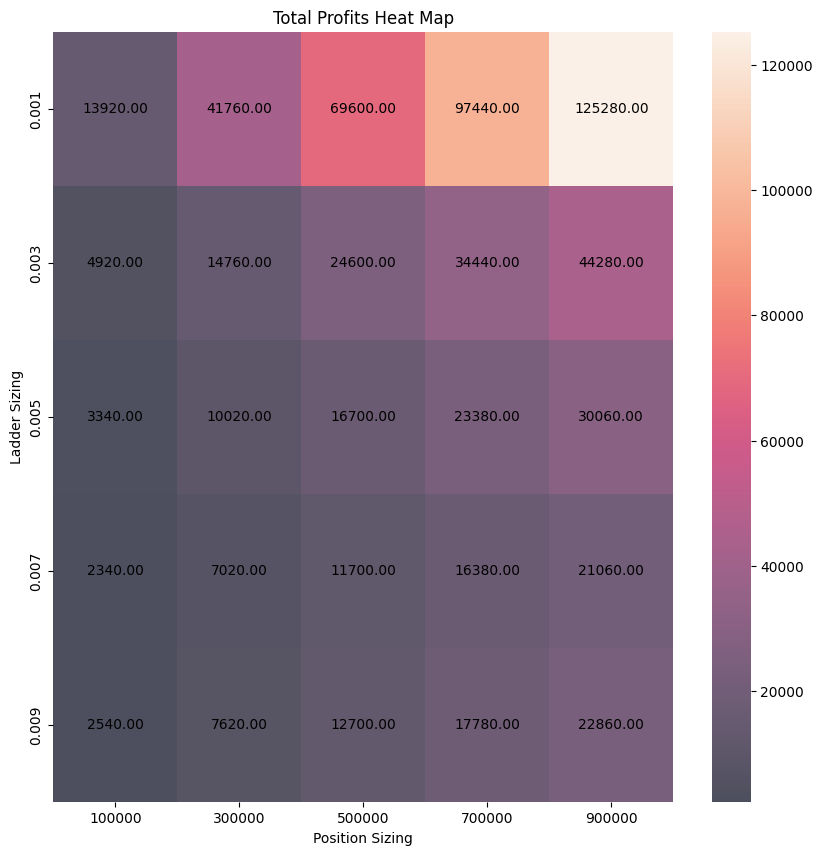

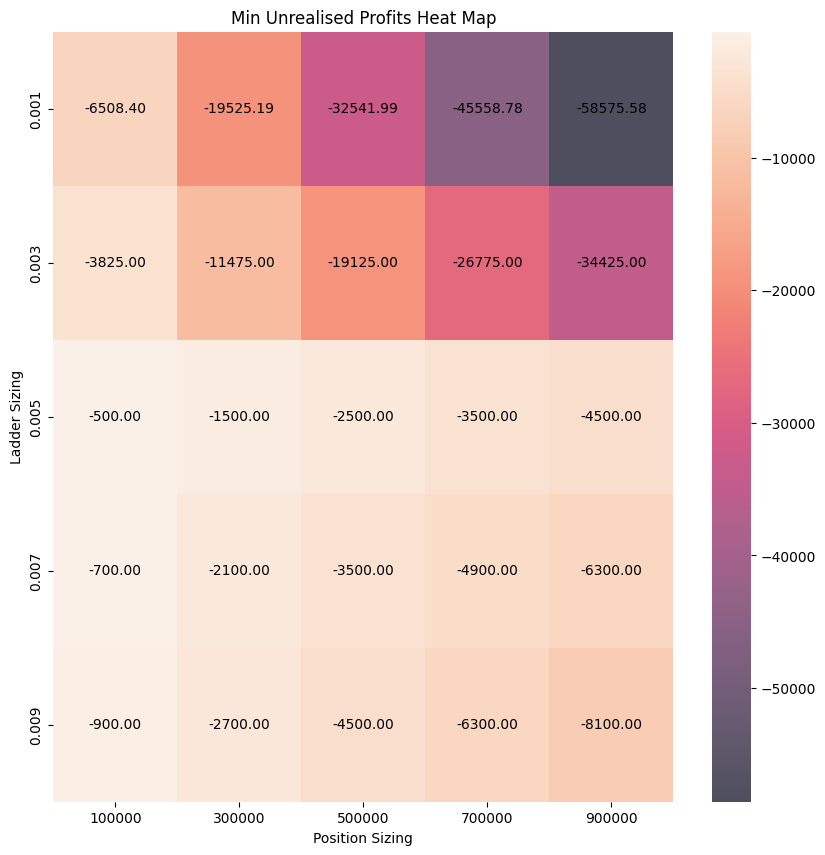

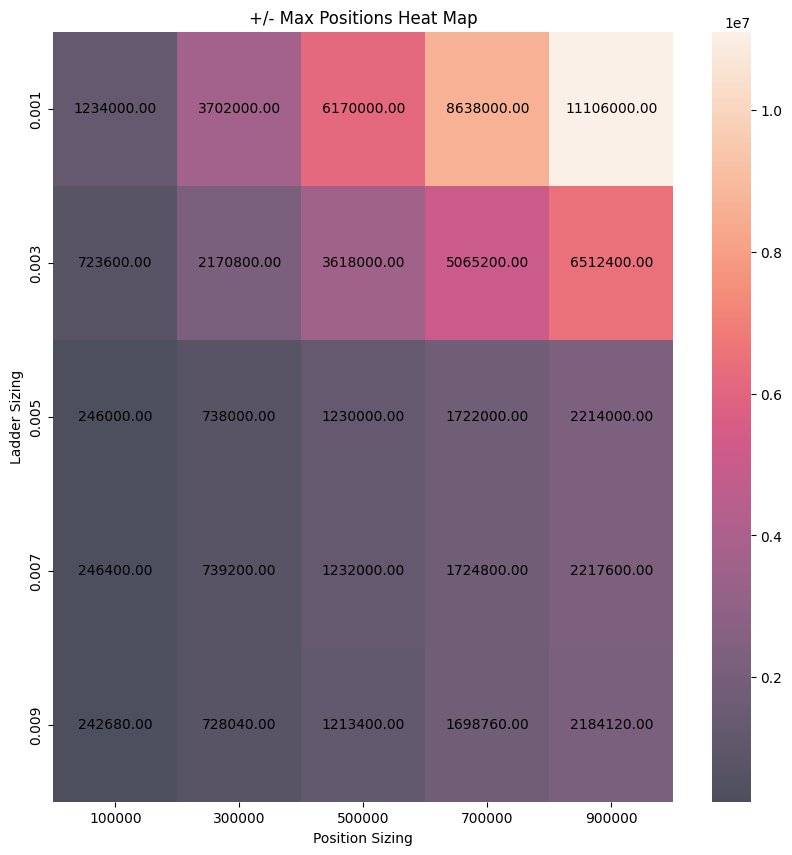

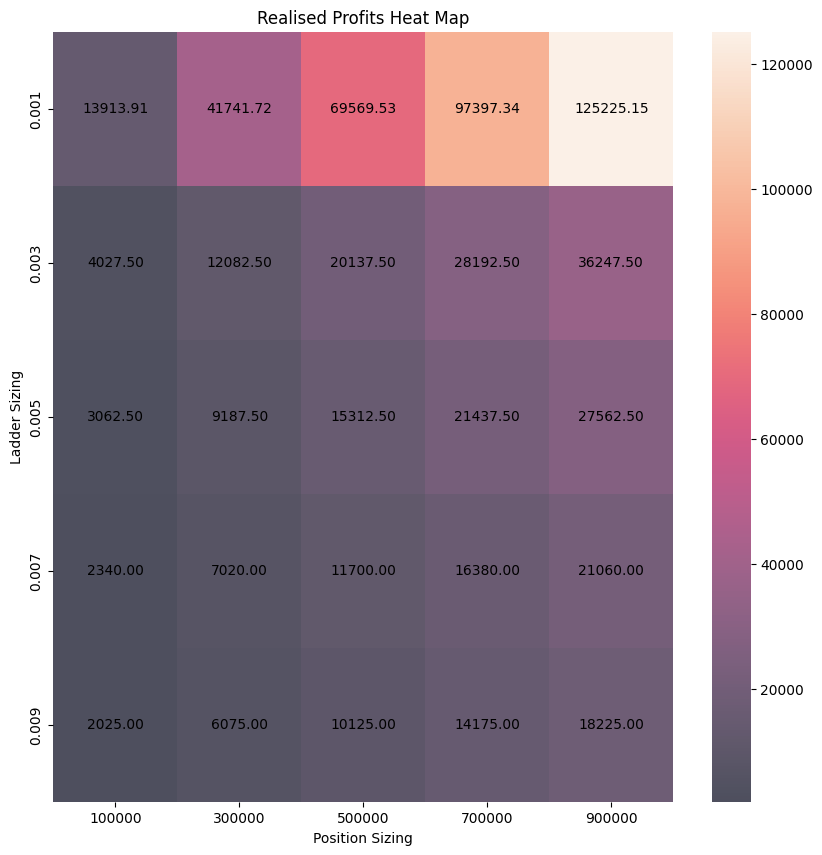

In [26]:
profit_heat_map(profits,ladder_sizing_grid,position_sizing_grid,'Total Profits')
profit_heat_map(U_PNLs,ladder_sizing_grid,position_sizing_grid,'Min Unrealised Profits')
profit_heat_map(max_positions,ladder_sizing_grid,position_sizing_grid,'+/- Max Positions')
profit_heat_map(R_PNLs,ladder_sizing_grid,position_sizing_grid,'Realised Profits')

In [33]:
trades = run_strategy_optimised(tick_data,0.001,900000,10)

## scipy 

In [6]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.005, 500000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'SLSQP',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x

In [7]:
print(' for scipy optimization with SLSQP, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

 for scipy optimization with SLSQP, the optimal G and optimal_n is:  0.005 500000.0 with profit 15312.5


In [36]:
print(' for scipy optimization with SLSQP, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

 for scipy optimization with SLSQP, the optimal G and optimal_n is:  0.005 500000.0 with profit 15312.5


In [15]:
tick_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']

In [16]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guesses = [[0.007, 700000], [0.003, 300000]]
best_result = None

for initial_guess in initial_guesses:
    result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method='SLSQP', 
                  constraints=[
                      {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
                      {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
                  ], 
                  options={'maxiter': 1, 'ftol': 1e-2})  # for example, increase to 100
    if best_result is None or result.fun < best_result.fun:
        best_result = result

optimal_G, optimal_n = best_result.x

In [ ]:
print(' for scipy optimization with trust-constr optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)


## optuna

In [ ]:
tick_data = data_gather_from_files('1 jan 2021','31 Dec 2021')['EURUSD.mid']

In [81]:
import optuna

def objective_optuna(trial, tick_data):
    G = trial.suggest_float("G", 0.001, 0.01)
    n = trial.suggest_float("n", 100000, 1000000)
    
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    
    # Constraints
    if max_position > 10e6:
        return float('inf')
    if U_PNL < -150e3:
        return float('inf')
    return -R_PNL  # We negate the value since we want to maximize ProfitD

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=100)

optimal_G = study.best_params["G"]
optimal_n = study.best_params["n"]


[I 2023-09-21 10:50:45,121] A new study created in memory with name: no-name-34d3b76f-20fc-4df7-9e4c-f28bb2e773de
[I 2023-09-21 10:51:03,662] Trial 0 finished with value: -41746.1991 and parameters: {'G': 0.004213441178399228, 'n': 990289.3783233741}. Best is trial 0 with value: -41746.1991.
[I 2023-09-21 10:51:22,362] Trial 1 finished with value: -45842.0616 and parameters: {'G': 0.00230038000802573, 'n': 725917.4475175046}. Best is trial 1 with value: -45842.0616.
[I 2023-09-21 10:51:41,215] Trial 2 finished with value: -31336.0154 and parameters: {'G': 0.0036153167892027036, 'n': 673839.1312312088}. Best is trial 1 with value: -45842.0616.
[I 2023-09-21 10:52:00,122] Trial 3 finished with value: inf and parameters: {'G': 0.0011849917275026259, 'n': 976946.9852846202}. Best is trial 1 with value: -45842.0616.
[I 2023-09-21 10:52:18,592] Trial 4 finished with value: -16599.9976 and parameters: {'G': 0.005241542816252239, 'n': 576388.8042075548}. Best is trial 1 with value: -45842.0616

In [82]:
optimal_G, optimal_n, - study.best_value

(0.001010260299722961, 796020.8320035312, 117444.7296)

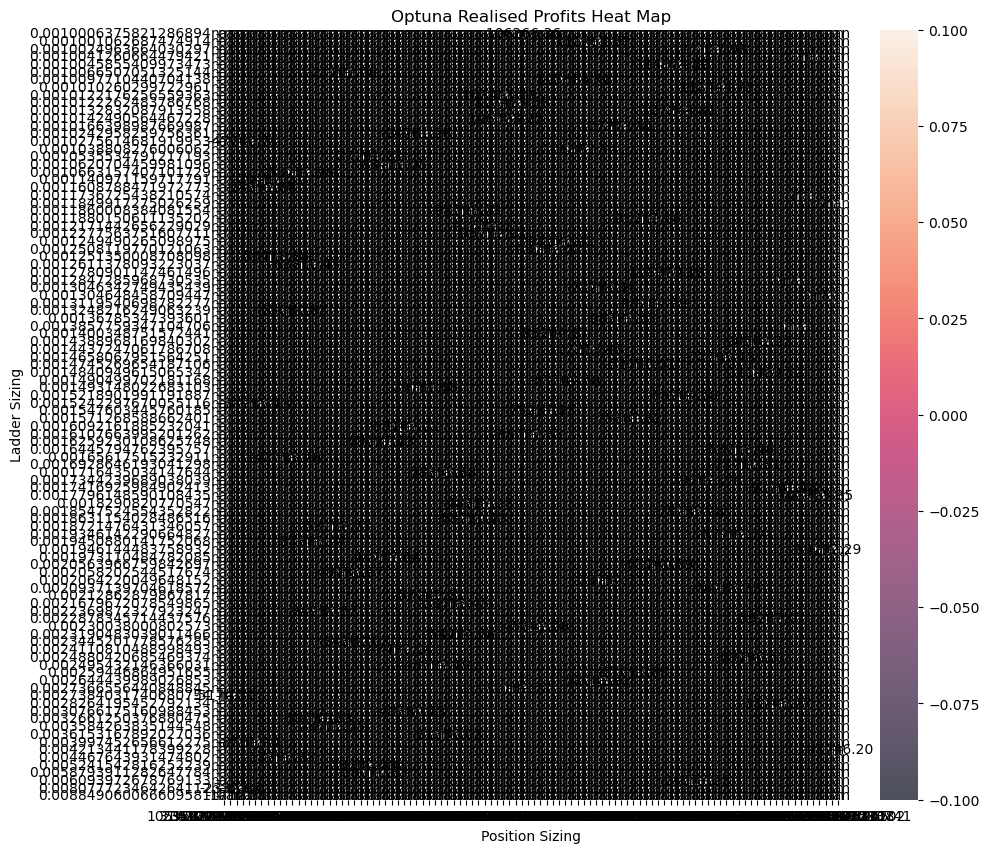

In [84]:
# Extract trials and arrange data
G_values_tested = []
n_values_tested = []
objectives = []

for trial in study.trials:
    G_values_tested.append(trial.params["G"])
    n_values_tested.append(trial.params["n"])
    objectives.append(trial.value)

# Create a matrix for the heatmap
G_unique = sorted(set(G_values_tested))
n_unique = sorted(set(n_values_tested))
heatmap_matrix = np.full((len(G_unique), len(n_unique)), np.nan)

for G_val, n_val, obj in zip(G_values_tested, n_values_tested, objectives):
    i = G_unique.index(G_val)
    j = n_unique.index(n_val)
    heatmap_matrix[i, j] = obj

# Plot the heatmap
profit_heat_map(heatmap_matrix, G_unique, n_unique, 'Optuna Realised Profits')

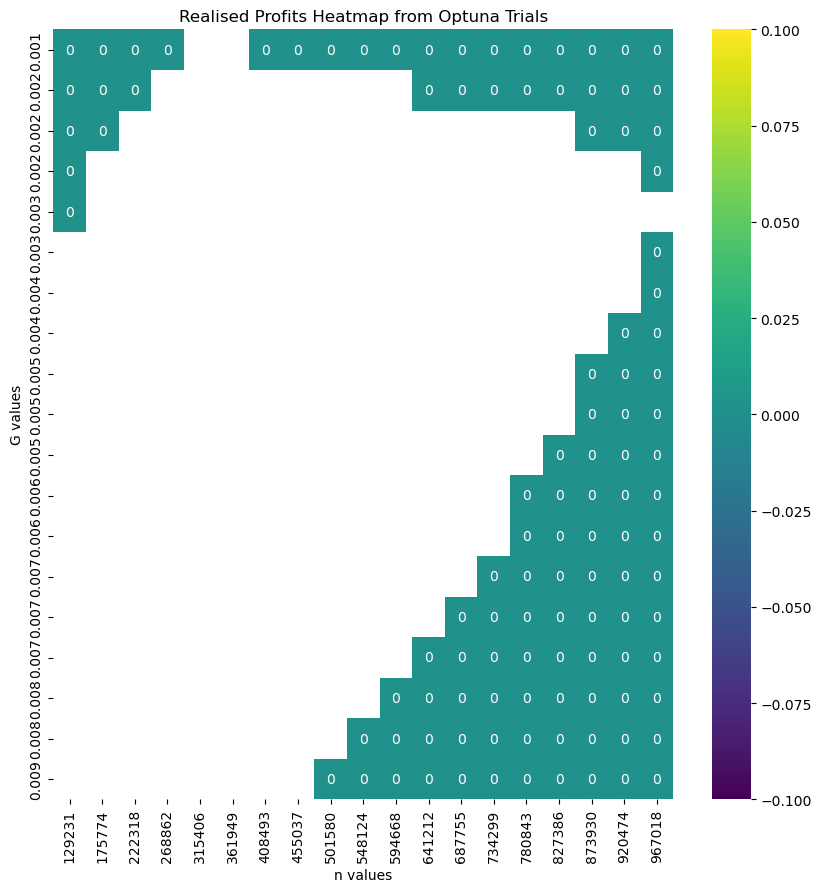

In [83]:
import numpy as np
from scipy.interpolate import griddata

def optuna_heat_map(study, num_bins=20):
    completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
    
    # Extract G and n values, and corresponding R_PNL values
    G_values = [trial.params["G"] for trial in completed_trials]
    n_values = [trial.params["n"] for trial in completed_trials]
    R_PNL_values = [-trial.value for trial in completed_trials]  # Negate to get original R_PNL values

    # Create a grid
    G_grid = np.linspace(min(G_values), max(G_values), num_bins)
    n_grid = np.linspace(min(n_values), max(n_values), num_bins)

    G_grid_centered = (G_grid[:-1] + G_grid[1:]) / 2
    n_grid_centered = (n_grid[:-1] + n_grid[1:]) / 2
    
    # Interpolate the data
    R_PNL_matrix = griddata((G_values, n_values), R_PNL_values, (G_grid_centered[None, :], n_grid_centered[:, None]), method='cubic', fill_value=0)

    # Plot
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(R_PNL_matrix, annot=True, cmap='viridis', xticklabels=np.round(n_grid_centered).astype(int), yticklabels=np.round(G_grid_centered, 3))
    plt.xlabel("n values")
    plt.ylabel("G values")
    plt.title("Realised Profits Heatmap from Optuna Trials")
    plt.show()

optuna_heat_map(study)


## visualisation after finding optimal G and n

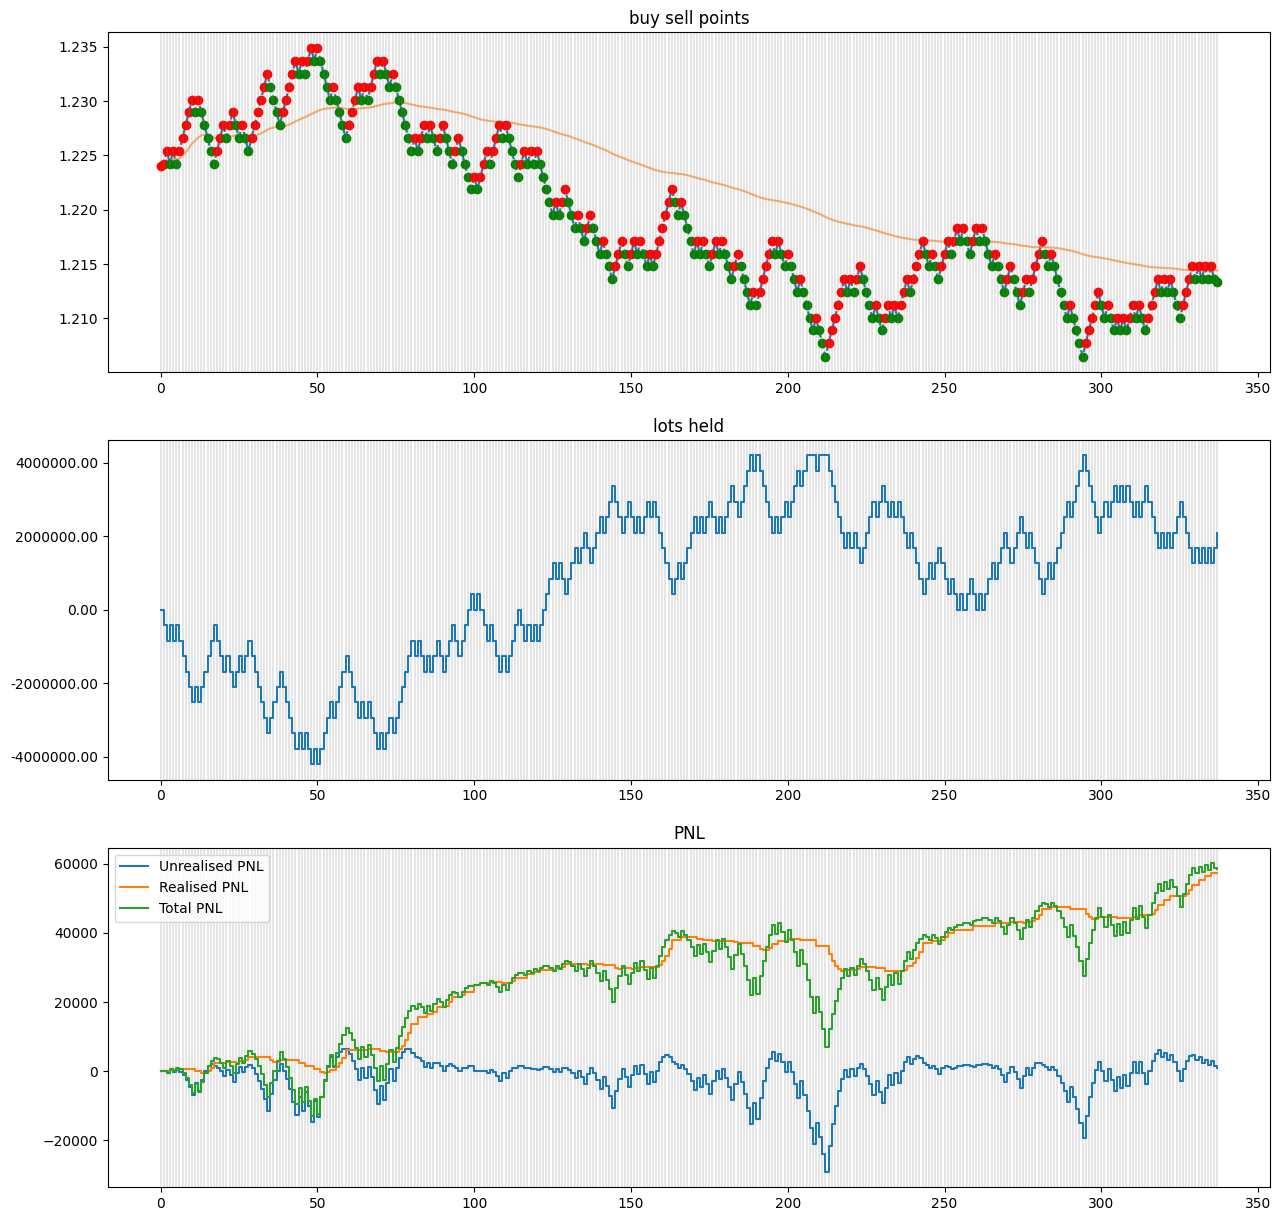

TypeError: cannot unpack non-iterable Styler object

In [50]:
_,a,b,c,d,e,f,g = run_strategy_eval(tick_data,optimal_G,optimal_n,trade_plot=True)
print('final profit is: ',a)
print('realised profit is: ',b)
print('final unrealised profit is: ',c)
print('max long lots held is: ',d)
print('max short lots held is :',e)
print('max long position is: ',f)
print('max short position is :',g)

In [52]:
import optuna

def objective_optuna(trial, tick_data):
    G = trial.suggest_float("G", 0.001, 0.01)
    n = trial.suggest_float("n", 100000, 1000000)
    d = trial.suggest_int("d", 3, 10)
    
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n,d)
    
    # Constraints
    if max_position > 10e6:
        return float('inf')
    if U_PNL < -150e3:
        return float('inf')
    return -R_PNL  # We negate the value since we want to maximize ProfitD

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=100)

optimal_G = study.best_params["G"]
optimal_n = study.best_params["n"]
optimal_d = study.best_params["d"]

[I 2023-09-20 22:31:31,633] A new study created in memory with name: no-name-f110ffd6-8c6b-4081-952e-2a3a5c6efc73
[I 2023-09-20 22:31:45,030] Trial 0 finished with value: -35044.7787 and parameters: {'G': 0.003470851422247713, 'n': 681363.1640485241, 'd': 8}. Best is trial 0 with value: -35044.7787.
[I 2023-09-20 22:31:58,298] Trial 1 finished with value: -3883.7332 and parameters: {'G': 0.009469785716406411, 'n': 641939.3709252469, 'd': 3}. Best is trial 0 with value: -35044.7787.
[I 2023-09-20 22:32:11,478] Trial 2 finished with value: -49168.9241 and parameters: {'G': 0.002323618850903853, 'n': 663018.8314295969, 'd': 5}. Best is trial 2 with value: -49168.9241.
[I 2023-09-20 22:32:24,688] Trial 3 finished with value: -10634.7707 and parameters: {'G': 0.004727999937868395, 'n': 250278.97201575327, 'd': 10}. Best is trial 2 with value: -49168.9241.
[I 2023-09-20 22:32:37,916] Trial 4 finished with value: -4668.1698 and parameters: {'G': 0.008060168171273668, 'n': 163222.72115031988, 

In [53]:
optimal_G, optimal_n,optimal_d, - study.best_value

(0.0012464126016342632, 881919.4444195931, 8, 116605.2363)

Optimization Method Nelder-Mead

In [ ]:
print(' for scipy optimization with Nelder-Mead, the optimal G and optimal_n is: ',optimal_G, optimal_n ,'with profit',-result.fun)

# Grid search & Random search

In [25]:
tick_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']

In [34]:
# Define the objective function
def objective(G,n, tick_data,d):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n,d)
    return R_PNL  # We not negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(G,n, tick_data,d):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n,d)
    if (max_position >10e6):
        return -1 #violated
    return 0

def constraint2(G,n, tick_data,d):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n,d)
    if (U_PNL < -150e3):
        return -1 #violated
    return 0

def check_constraints(G, n,tick_data,d):
    constraint1_okay = constraint1(G, n,tick_data,d) == 0
    constraint2_okay = constraint2(G, n,tick_data,d) == 0
    return constraint1_okay and constraint2_okay

In [35]:
# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 500000)  # 5000001 is the stop value to include 5000000

# For d: Values from 5 to 15 with an interval of 1
d_values = np.arange(5, 16, 1)  # 16 is the stop value to include 15


## Grid search

In [36]:
best_profit = float('-inf')
best_G = None
best_n = None
best_d = None

# Grid Search
for G in G_values:
    for d in d_values:
        for n in n_values:
            if check_constraints(G, n,tick_data,d):
                current_profit = objective(G, n, tick_data,d)
                if current_profit > best_profit:
                    best_profit = current_profit
                    best_G = G
                    best_n = n
                    best_d = d

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal d: {best_d}")

    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

KeyboardInterrupt: 

## Only G and n

In [43]:
# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 750000)  # 5000001 is the stop value to include 5000000

In [39]:
# Define the objective function
def objective(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return R_PNL  # We not negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    if (max_position >10e6):
        return -1 #violated
    return 0

def constraint2(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    if (U_PNL < -150e3):
        return -1 #violated
    return 0

def check_constraints(G, n,tick_data):
    constraint1_okay = constraint1(G, n,tick_data) == 0
    constraint2_okay = constraint2(G, n,tick_data) == 0
    return constraint1_okay and constraint2_okay

In [41]:
# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Grid Search
for G in G_values:
    for n in n_values:
        if check_constraints(G, n,tick_data):
            current_profit = objective(G, n, tick_data)
            if current_profit > best_profit:
                best_profit = current_profit
                best_G = G
                best_n = n

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")

    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

KeyboardInterrupt: 

In [42]:
# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Grid Search
for G in G_values:
    for n in n_values:
        # Calculate results once for each (G, n) pair
        profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)

        # Check constraints using stored results
        constraint1_okay = (max_position <= 10e6)
        constraint2_okay = (U_PNL >= -150e3)

        if constraint1_okay and constraint2_okay:
            current_profit = R_PNL  # Using stored R_PNL value
            if current_profit > best_profit:
                best_profit = current_profit
                best_G = G
                best_n = n

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")


KeyboardInterrupt: 

Optimal G: 0.005
Optimal n: 3600000
Optimal net profit: 110250.0


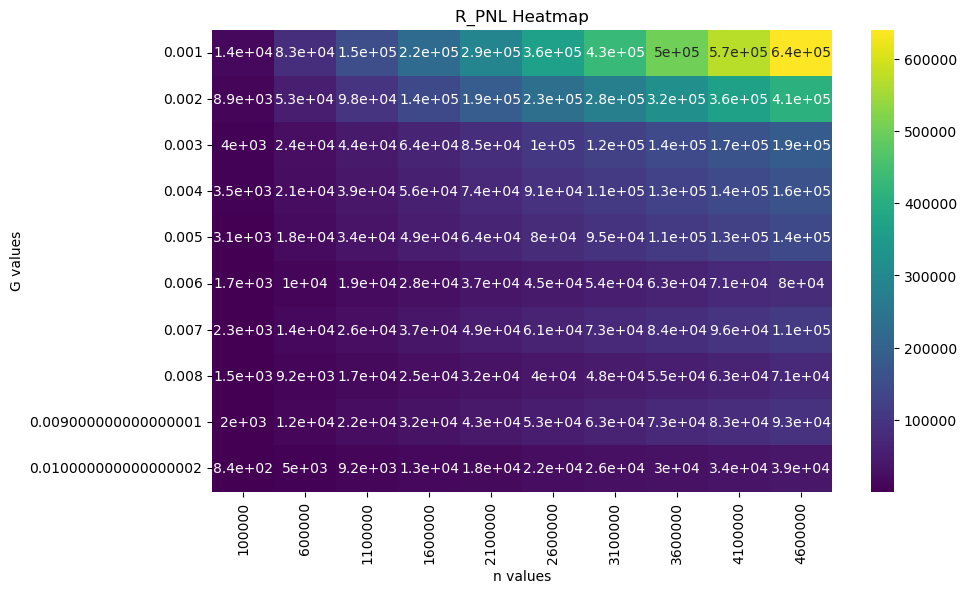

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 500000)  # 5000001 is the stop value to include 5000000

# Initialize a matrix for storing R_PNL values
R_PNL_matrix = np.zeros((len(G_values), len(n_values)))

# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Grid Search
for i, G in enumerate(G_values):
    for j, n in enumerate(n_values):
        # Calculate results once for each (G, n) pair
        profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)
        
        # Store the result in the matrix
        R_PNL_matrix[i, j] = R_PNL

        # Check constraints using stored results
        constraint1_okay = (max_position <= 10e6)
        constraint2_okay = (U_PNL >= -150e3)

        if constraint1_okay and constraint2_okay:
            if R_PNL > best_profit:
                best_profit = R_PNL
                best_G = G
                best_n = n

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(R_PNL_matrix, annot=True, xticklabels=n_values, yticklabels=G_values, cmap='viridis')
plt.xlabel('n values')
plt.ylabel('G values')
plt.title('R_PNL Heatmap')
plt.show()

In [68]:
def profit_heat_map(profits, ladder_sizing, position_sizing,title):
    plt.figure(figsize=(10,10))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True,alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, ladder_sizing)
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title(title+' Heat Map')
    plt.show()

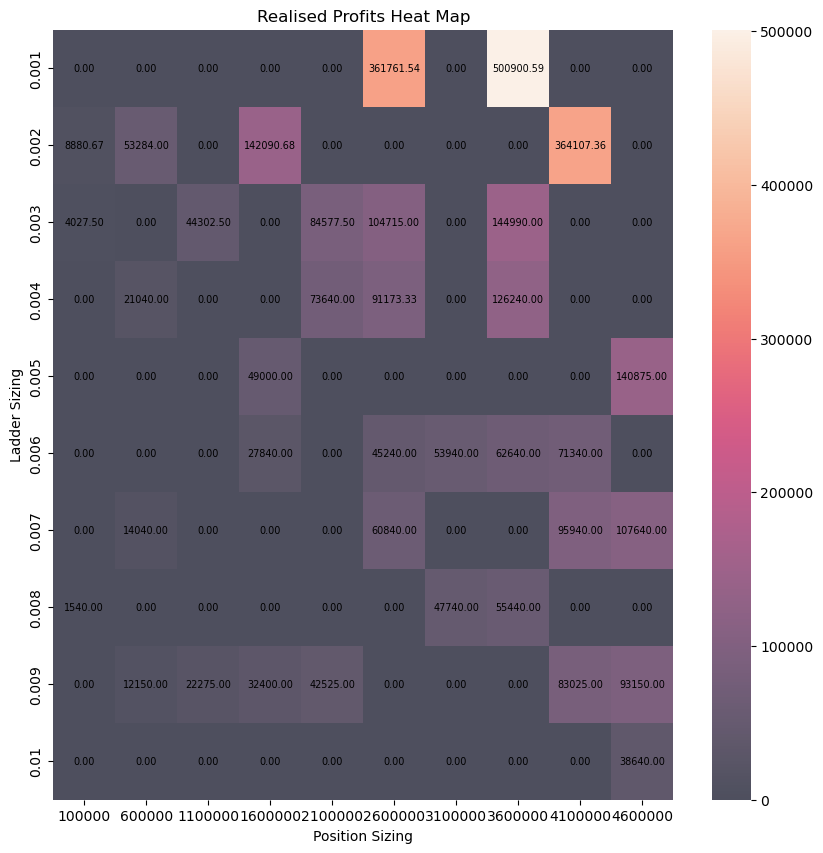

In [72]:
def profit_heat_map(profits, ladder_sizing, position_sizing, title):
    plt.figure(figsize=(10,10))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True, alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=7)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    
    # Round the ladder_sizing values for ytick labels
    rounded_labels = [round(val, 3) for val in ladder_sizing]  # Rounding to 3 decimal places
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, rounded_labels)
    
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title(title + ' Heat Map')
    plt.show()

profit_heat_map(R_PNL_matrix, G_values, n_values, 'Realised Profits')


G,n,d

## Random Search

In [33]:
import numpy as np

num_iterations = 100  # Example: 100 random combinations

best_profit = float('-inf')
best_G = None
best_n = None
best_d = None

# Possible values remain the same
G_values = np.arange(0.001, 0.011, 0.001)
n_values = np.arange(500000, 1000001, 500000)
d_values = np.arange(5, 10, 1)

# The constraints and objective function remain the same

# Random Search
for _ in range(num_iterations):
    # Randomly select a value for each parameter
    G = np.random.choice(G_values)
    n = np.random.choice(n_values)
    d = np.random.choice(d_values)

    if check_constraints(G, n, tick_data, d):
        current_profit = objective(G, n, tick_data, d)
        if current_profit > best_profit:
            best_profit = current_profit
            best_G = G
            best_n = n
            best_d = d

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal d: {best_d}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")


Optimal G: 0.005
Optimal n: 2100000
Optimal d: 7
Optimal net profit: 64312.5


In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# G and n values
G_values = np.arange(0.001, 0.011, 0.001)
n_values = np.arange(500000, 1000001, 500000)

# Number of random combinations to try
num_iterations = 2

# Initialize a matrix for storing R_PNL values
R_PNL_matrix = np.zeros((num_iterations, 2))

# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

for i in range(num_iterations):
    # Randomly sample G and n values
    G = np.random.choice(G_values)
    n = np.random.choice(n_values)

    # Calculate results for the randomly selected (G, n) pair
    profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)
    
    # Store the result in the matrix
    R_PNL_matrix[i] = [G, R_PNL]
    
    # Check constraints using stored results
    constraint1_okay = (max_position <= 10e6)
    constraint2_okay = (U_PNL >= -150e3)

    if constraint1_okay and constraint2_okay:
        if R_PNL > best_profit:
            best_profit = R_PNL
            best_G = G
            best_n = n

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")


Optimal G: 0.010000000000000002
Optimal n: 1000000
Optimal net profit: 8400.0


Optimal G: 0.009000000000000001
Optimal n: 4100000
Optimal net profit: 83025.0


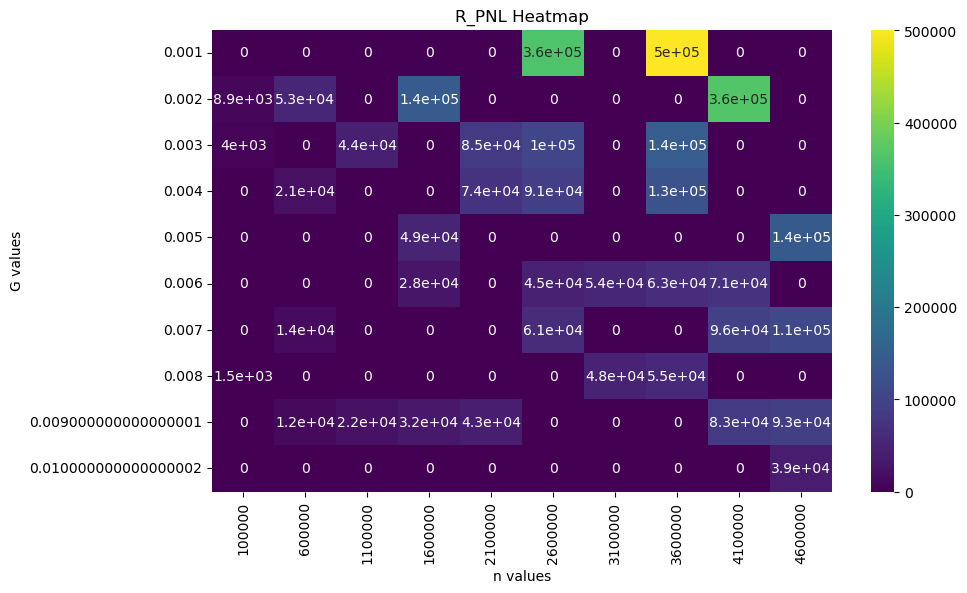

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 500000)  # 5000001 is the stop value to include 5000000

# Initialize a matrix for storing R_PNL values
R_PNL_matrix = np.zeros((len(G_values), len(n_values)))

# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Random Search with 50 iterations
for iteration in range(50):
    G = np.random.choice(G_values)
    n = np.random.choice(n_values)

    # Find index in G_values and n_values for storing in R_PNL_matrix
    i = np.where(G_values == G)[0][0]
    j = np.where(n_values == n)[0][0]
    
    # Calculate results once for each (G, n) pair
    profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)
    
    # Store the result in the matrix
    R_PNL_matrix[i, j] = R_PNL

    # Check constraints using stored results
    constraint1_okay = (max_position <= 10e6)
    constraint2_okay = (U_PNL >= -150e3)

    if constraint1_okay and constraint2_okay:
        if R_PNL > best_profit:
            best_profit = R_PNL
            best_G = G
            best_n = n

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(R_PNL_matrix, annot=True, xticklabels=n_values, yticklabels=G_values, cmap='viridis')
plt.xlabel('n values')
plt.ylabel('G values')
plt.title('R_PNL Heatmap')
plt.show()


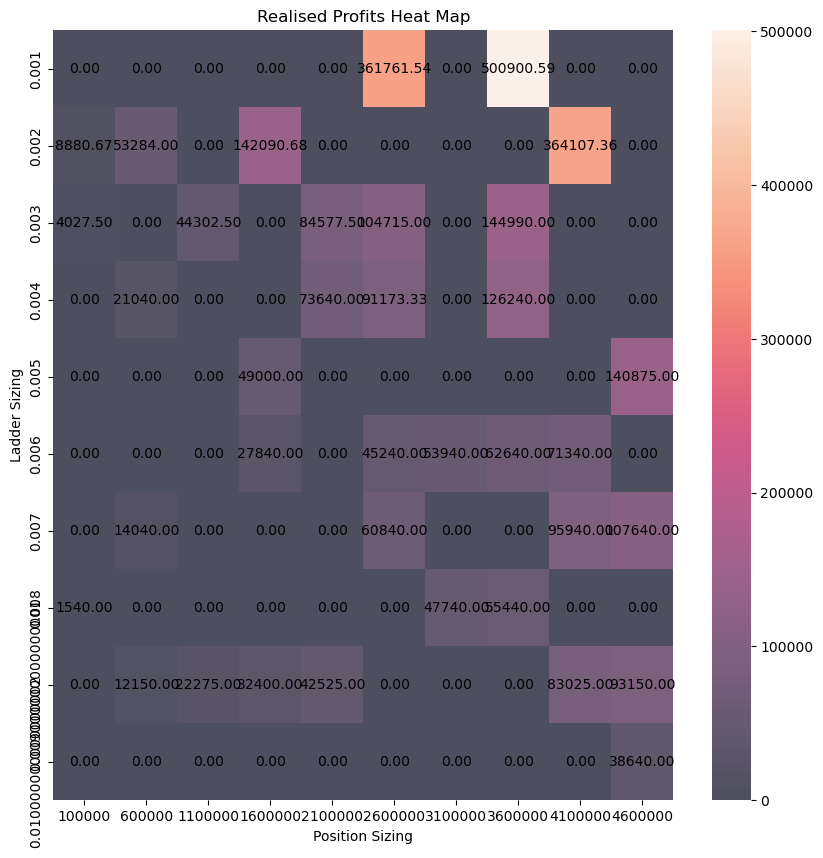

In [71]:
profit_heat_map(R_PNL_matrix, G_values, n_values, 'Realised Profits')


# Nelder-Mead

In [ ]:
from scipy.optimize import minimize

# Define the objective function
def objective(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return -R_PNL  # We negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return 10e6 - max_position

def constraint2(params, tick_data):
    G, n = params
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return U_PNL + 150e3

# Define bounds
bounds = [(0.001, 0.01), (100000, 2000000)]

# Optimization
initial_guess = [0.002, 800000]  # Initial guess for G and n
result = minimize(objective, initial_guess, args=(tick_data,), bounds=bounds, method = 'Nelder-Mead',constraints=[
    {"type": "ineq", "fun": constraint1, "args": (tick_data,)},
    {"type": "ineq", "fun": constraint2, "args": (tick_data,)}
])

optimal_G, optimal_n = result.x